## **Identifying differences between audio signals**
In this notebook, I try to use different features of librosa, scipy, and torchaudio to identify differences between ball-racket impacts and simply noise from the intervening time intervals.

librosa and pytorchaudio are quite similar, and I think pytorchaudio builds on librosa. I though to give it a try because pytorchaudio is better integrated with pytorch, one of the go-to tools for ML.

The bottomline for this notebook: **cross-correlation (scipy.signal.correlate)** between two signals could be a useful tool, but even better might be the **cross-spectral-density (signal.scipy.csd)**, which is the fourier transform of the cross-correlation. 

In [2]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.9.0+cu102
0.9.0


In [6]:
import scipy
import librosa
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display
from scipy import signal
import numpy as np

### **Importing audio files**

You need to have the files BF85.wav, BF28.wav, BF48.wav, and BallRacketHitsAtHome.wav in the same folder from which you are running this notebook. Otherwise, you'll have to rename the paths to these files.

In [18]:
waveform1, sample_rate1 = torchaudio.load('BF85.wav')
waveform2, sample_rate2 = torchaudio.load('BF28.wav')
waveform3, sample_rate3 = torchaudio.load('BF48.wav')
waveform1 = waveform1 - torch.mean(waveform1)
waveform2 = waveform2 - torch.mean(waveform2)
waveform3 = waveform3 - torch.mean(waveform3)

baboAtHome, fs = torchaudio.load('BallRacketHitsAtHome.wav')
baboAtHome = baboAtHome - torch.mean(baboAtHome)
baboAtHome = baboAtHome[0]
noiseSample = baboAtHome[20000:27000]

In [5]:
len(waveform1[0])

7000

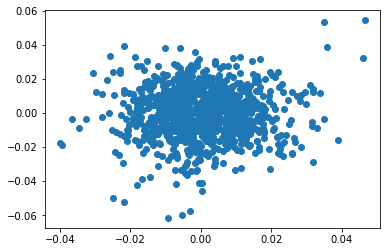

In [21]:
upto = 1024
plt.scatter(waveform1[0][:upto], waveform2[0][:upto])

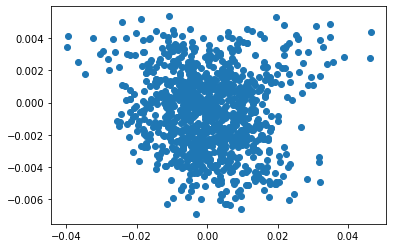

In [22]:
plt.scatter(waveform1[0][:upto], noiseSample[:upto])

### **Computing cross-correlation between two signals**

In [59]:
corr11 = signal.correlate(waveform1[0][:1024]/torch.max(waveform1[0][:1024]), 
                          waveform1[0][:1024]/torch.max(waveform1[0][:1024]), mode='full')
lags11 = signal.correlation_lags(len(waveform1[0][:1024]), len(waveform1[0][:1024]), mode="full")
corr22 = signal.correlate(waveform2[0][:1024]/torch.max(waveform2[0][:1024]), 
                          waveform2[0][:1024]/torch.max(waveform2[0][:1024]), mode='full')
corr12 = signal.correlate(waveform1[0][:1024]/torch.max(waveform1[0][:1024]), 
                          waveform2[0][:1024]/torch.max(waveform2[0][:1024]), mode='full')

In [28]:
len(waveform2[0])

7000

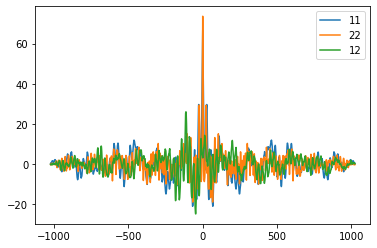

In [62]:
plt.plot(lags11, corr11, label='11')
plt.plot(lags11, corr22, label='22')
plt.plot(lags11, corr12, label='12')
plt.legend(loc='upper right')

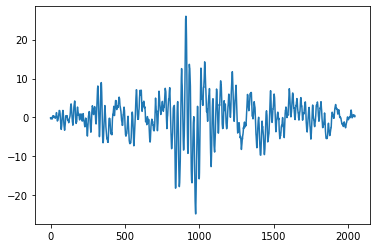

In [63]:
plt.plot(corr12)

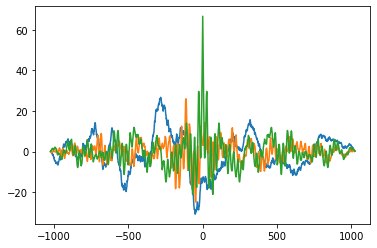

In [70]:
corr1noise = signal.correlate(waveform1[0][:1024]/torch.max(waveform1[0][:1024]), noiseSample/torch.max(noiseSample), mode='full')
lags1noise = signal.correlation_lags(len(waveform1[0][:1024]), len(noiseSample), mode="full")

plt.plot(lags1noise, corr1noise)
plt.plot(lags11, corr12)
plt.plot(lags11, corr11)

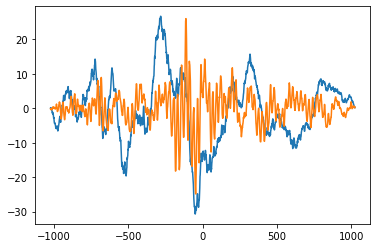

In [71]:
plt.plot(lags1noise, corr1noise)
plt.plot(lags11, corr12)

### **Computing the cross-spectral density**

inputs - two signals of equal length you wish to compare.
output is in the form of frequency array, csd array. CSD, like Fourier transforms, is a complex number (array of). That is why I use np.abs() to plot it. The phase of the complex number, np.angle, did not yield any interesting information.

The csd did. The CSD of two different ball-racket impacts exhibit peaks at higher frequencies that are absent from ball-noise CSD.

***Need to test this for all snippet files that have been generated. Do ball-racket and ball-ground interactions have different features in the CSD amongst themselves as opposed to in the CSD with noise?***

In [12]:
upto = 2048
noiseSample = noiseSample[0:upto]

freq1n, csd1noise = signal.csd(waveform1[0][:upto]/torch.max(waveform1[0][:upto]), noiseSample/torch.max(noiseSample), fs=sample_rate1)
freq12, csd12 = signal.csd(waveform1[0][:upto]/torch.max(waveform1[0][:upto]), waveform2[0][:upto]/torch.max(waveform2[0][:upto]), fs=sample_rate1)
freq13, csd13 = signal.csd(waveform1[0][:upto]/torch.max(waveform1[0][:upto]), waveform3[0][:upto]/torch.max(waveform3[0][:upto]), fs=sample_rate1)
freq23, csd23 = signal.csd(waveform2[0][:upto]/torch.max(waveform2[0][:upto]), waveform3[0][:upto]/torch.max(waveform3[0][:upto]), fs=sample_rate2)
freq2n, csd2noise = signal.csd(waveform2[0][:upto]/torch.max(waveform2[0][:upto]), noiseSample/torch.max(noiseSample), fs=sample_rate2)
freq3n, csd3noise = signal.csd(waveform3[0][:upto]/torch.max(waveform3[0][:upto]), noiseSample/torch.max(noiseSample), fs=sample_rate3)

(0.0, 4000.0)

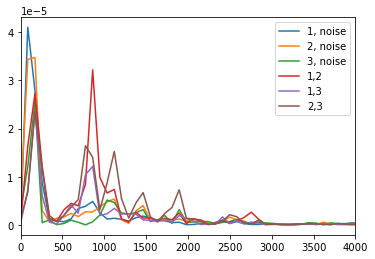

In [13]:
plt.plot(freq1n, np.abs(csd1noise), label = '1, noise')
plt.plot(freq2n, np.abs(csd2noise), label = '2, noise')
plt.plot(freq3n, np.abs(csd3noise), label = '3, noise')
plt.plot(freq12, np.abs(csd12), label = '1,2')
plt.plot(freq13, np.abs(csd13), label = '1,3')
plt.plot(freq23, np.abs(csd23), label = '2,3')
plt.legend(loc='upper right')
plt.xlim([0, 4000])

(0.0, 4000.0)

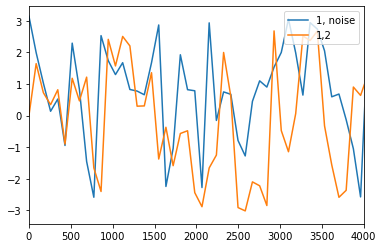

In [93]:
plt.plot(freq1n, np.angle(csd1noise), label = '1, noise')
#plt.plot(freq2n, np.angle(csd2noise), label = '2, noise')
#plt.plot(freq3n, np.angle(csd3noise), label = '3, noise')
plt.plot(freq12, np.angle(csd12), label = '1,2')
#plt.plot(freq13, np.angle(csd13), label = '1,3')
#plt.plot(freq23, np.angle(csd23), label = '2,3')
plt.legend(loc='upper right')
plt.xlim([0, 4000])